# Dynamic inference performance comparison on hematopoiesis Dataset

Notebook compares cross-boundary correctness (CBC) and terminal state identification performance.

## Library imports

In [2]:
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib import rcParams

import cellrank as cr
import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking._tsi import plot_TSI, TSI_score
from rgv_tools.core import METHOD_PALETTE_TSI
from rgv_tools.plotting._significance import add_significance, get_significance
from rgv_tools.utils._stools import reverse_cluster, reverse_cluster_dict

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "hematopoiesis"

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [5]:
VELOCITY_METHODS = ["regvelo_unregularized", "regvelo", "scvelo", "velovi"]

In [6]:
TERMINAL_STATES = ["Ery", "Mon", "Bas", "Neu", "Meg"]

In [7]:
STATE_TRANSITIONS = [
    ("HSC", "GMP-like"),
    ("GMP-like", "Mon"),
    ("HSC", "MEP-like"),
    ("MEP-like", "Ery"),
    ("MEP-like", "Meg"),
    ("MEP-like", "Bas"),
]

STATE_TRANSITIONS_REVERSE = [
    ("GMP-like", "HSC"),
    ("Mon", "GMP-like"),
    ("MEP-like", "HSC"),
    ("Ery", "MEP-like"),
    ("Meg", "MEP-like"),
    ("Bas", "MEP-like"),
]

## Data loading

computing velocity graph (using 1/128 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


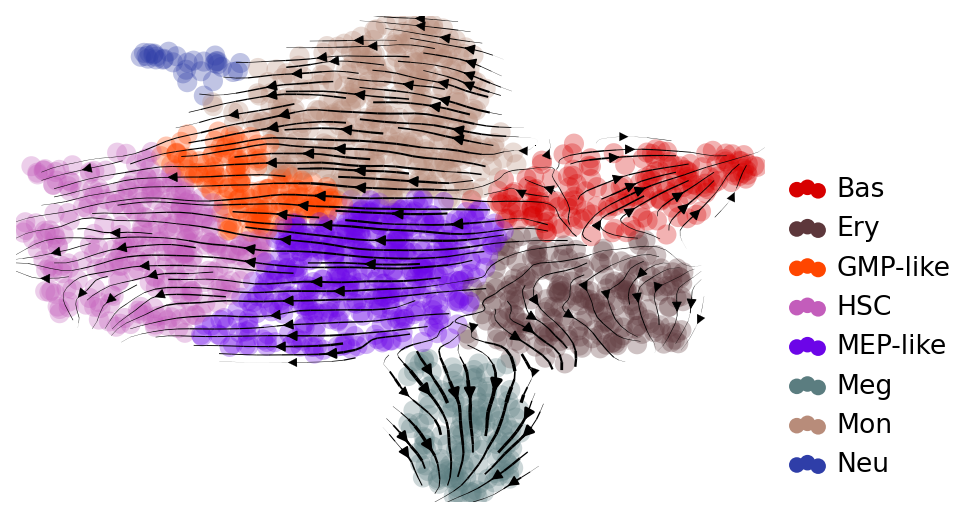

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

computing velocity graph (using 1/128 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


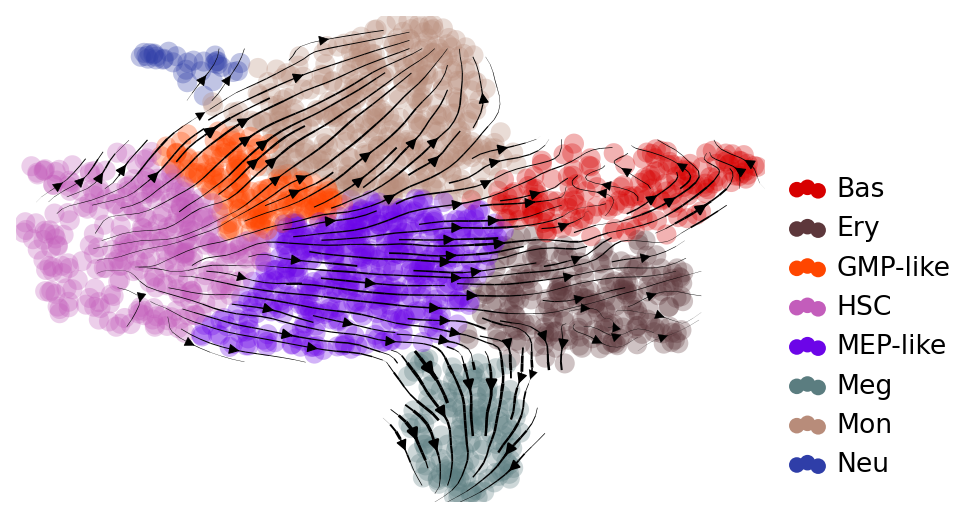

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

computing velocity graph (using 1/128 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


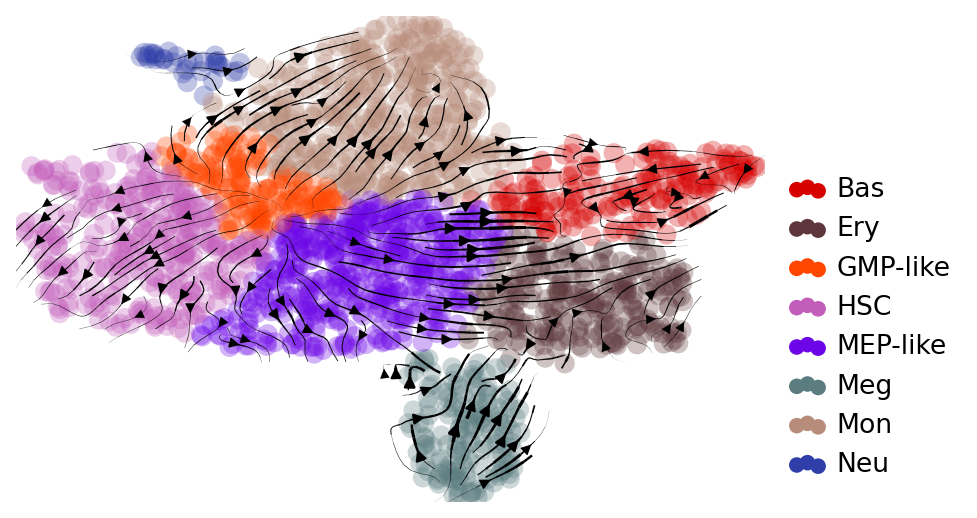

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

computing velocity graph (using 1/128 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


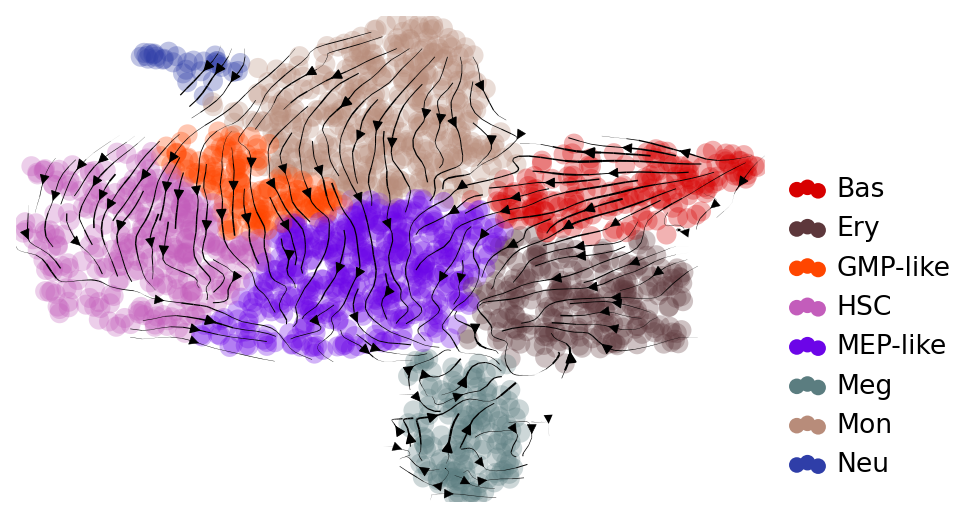

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

In [8]:
vks = {}

for method in VELOCITY_METHODS:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_{method}.h5ad")

    del adata.var["velocity_genes"]
    ## Visualize velocity on UMAP
    with mplscience.style_context():
        fig, ax = plt.subplots(figsize=(6, 4))
        scv.tl.velocity_graph(adata)
        scv.pl.velocity_embedding_stream(
            adata, basis="umap", color="cell_type", title="", legend_loc="lower right", ax=ax
        )

        if SAVE_FIGURES:
            fig.savefig(
                FIG_DIR / DATASET / f"vector_field_{method}.svg", format="svg", transparent=True, bbox_inches="tight"
            )
        plt.show()

    ## construct graph
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    vks[method] = vk

## Comparing RegVelo and scVelo

### Measuring forward CBC

In [9]:
cluster_key = "cell_type"
rep = "X_pca"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_rgv_wo = vks["regvelo_unregularized"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_rgv_wo + 1)),
            }
        )
    )
score_df_forward = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


In [10]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df_forward["State transition"].isin([f"{source} - {target}"])
    a = score_df_forward.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [11]:
significances_forward = significances.copy()
significances_forward

{'HSC - GMP-like': '*',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': '**',
 'MEP-like - Bas': '**'}

### Measuring backward CBC

In [12]:
score_df = []
for source, target in tqdm(STATE_TRANSITIONS_REVERSE):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_rgv_wo = vks["regvelo_unregularized"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((2 - cbc_rgv) / (2 - cbc_rgv_wo)),  # (1 - cbc) + 1
            }
        )
    )
score_df_backward = pd.concat(score_df)

100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


In [13]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS_REVERSE:
    obs_mask = score_df_backward["State transition"].isin([f"{source} - {target}"])
    a = score_df_backward.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [14]:
significances_backward = significances.copy()
significances_backward

{'GMP-like - HSC': '***',
 'Mon - GMP-like': '***',
 'MEP-like - HSC': '***',
 'Ery - MEP-like': '***',
 'Meg - MEP-like': 'n.s.',
 'Bas - MEP-like': 'n.s.'}

In [15]:
score_df_backward["State transition"] = score_df_backward["State transition"].apply(reverse_cluster)

In [16]:
score_df_forward.loc[:, "Direction"] = "Forward"
score_df_backward.loc[:, "Direction"] = "Backward"
score_df = pd.concat([score_df_forward, score_df_backward])

In [17]:
significances_backward = reverse_cluster_dict(significances_backward)
significances_backward

{'HSC - GMP-like': '***',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': 'n.s.'}

### Plot CBC

In [18]:
score_forward = []
for i in list(significances_forward.keys()):
    score_forward.append(significances_forward[i])

score_backward = []
for i in list(significances_backward.keys()):
    score_backward.append(significances_backward[i])

In [19]:
sig_m = pd.DataFrame(
    {
        "State transition": list(significances_forward.keys()) + list(significances_backward.keys()),
        "Direction": ["Forward"] * 6 + ["Backward"] * 6,
        "Sign": score_forward + score_backward,
    }
)

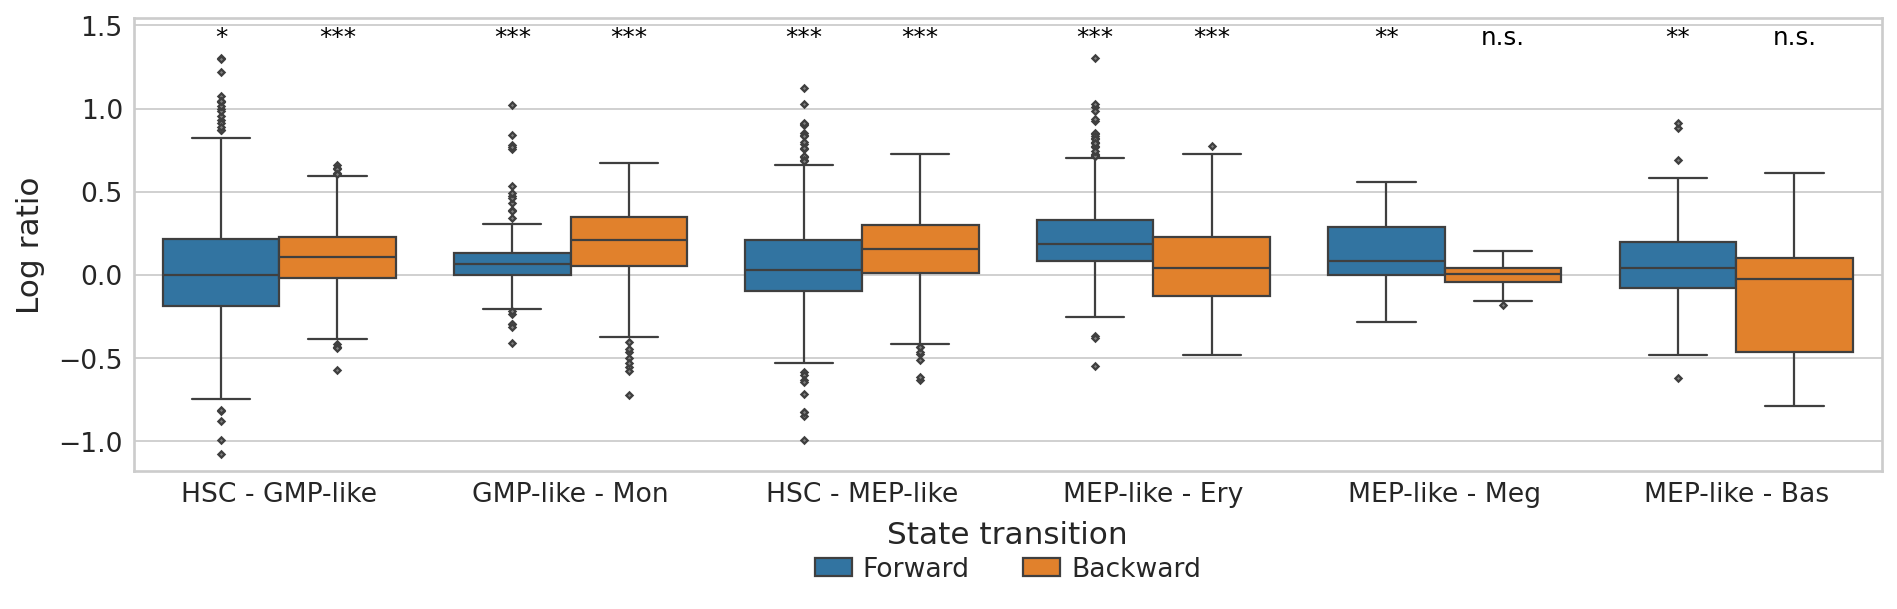

In [20]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(x="State transition", y="Log ratio", hue="Direction", data=score_df, flierprops=flierprops, ax=ax)

    # Calculate the maximum Y value from the data to set a uniform height for significance indicators
    y_max = score_df["Log ratio"].max()

    # Add significance indicators
    cell_types = score_df["State transition"].unique()
    categories = score_df["Direction"].unique()

    for i, cell_type in enumerate(cell_types):
        for j, category in enumerate(categories):
            star = sig_m[(sig_m["State transition"].isin([cell_type])) & (sig_m["Direction"].isin([category]))][
                "Sign"
            ].tolist()[0]

            # Calculate the position of the asterisk
            x = i + (j - 0.5) * 0.4  # Adjust the position of the asterisk
            y = y_max + 0.05  # Uniform height for all asterisks

            ax.text(x, y, star, ha="center", va="bottom", color="black")

    plt.ylim(score_df["Log ratio"].min() - 0.1, score_df["Log ratio"].max() + 0.24)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(categories))
    # Apply tight layout
    plt.tight_layout()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "transition_benchmark_velocity.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()

## Comparing RegVelo and scVelo

### Measuring forward CBC

In [21]:
cluster_key = "cell_type"
rep = "X_pca"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = vks["scvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_scv + 1)),
            }
        )
    )
score_df_forward = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


In [22]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df_forward["State transition"].isin([f"{source} - {target}"])
    a = score_df_forward.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [23]:
significances_forward = significances.copy()
significances_forward

{'HSC - GMP-like': '**',
 'GMP-like - Mon': '**',
 'HSC - MEP-like': 'n.s.',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': '*'}

### Measuring backward CBC

In [24]:
score_df = []
for source, target in tqdm(STATE_TRANSITIONS_REVERSE):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = vks["scvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((2 - cbc_rgv) / (2 - cbc_scv)),
            }
        )
    )
score_df_backward = pd.concat(score_df)

100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


In [25]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS_REVERSE:
    obs_mask = score_df_backward["State transition"].isin([f"{source} - {target}"])
    a = score_df_backward.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [26]:
significances_backward = significances.copy()
significances_backward

{'GMP-like - HSC': '***',
 'Mon - GMP-like': '***',
 'MEP-like - HSC': '***',
 'Ery - MEP-like': '***',
 'Meg - MEP-like': '***',
 'Bas - MEP-like': '***'}

In [27]:
score_df_backward["State transition"] = score_df_backward["State transition"].apply(reverse_cluster)

In [28]:
score_df_forward.loc[:, "Direction"] = "Forward"
score_df_backward.loc[:, "Direction"] = "Backward"
score_df = pd.concat([score_df_forward, score_df_backward])

In [29]:
significances_backward = reverse_cluster_dict(significances_backward)
significances_backward

{'HSC - GMP-like': '***',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': '***',
 'MEP-like - Bas': '***'}

### Plot CBC

In [30]:
score_forward = []
for i in list(significances_forward.keys()):
    score_forward.append(significances_forward[i])

score_backward = []
for i in list(significances_backward.keys()):
    score_backward.append(significances_backward[i])

In [31]:
sig_m = pd.DataFrame(
    {
        "State transition": list(significances_forward.keys()) + list(significances_backward.keys()),
        "Direction": ["Forward"] * 6 + ["Backward"] * 6,
        "Sign": score_forward + score_backward,
    }
)

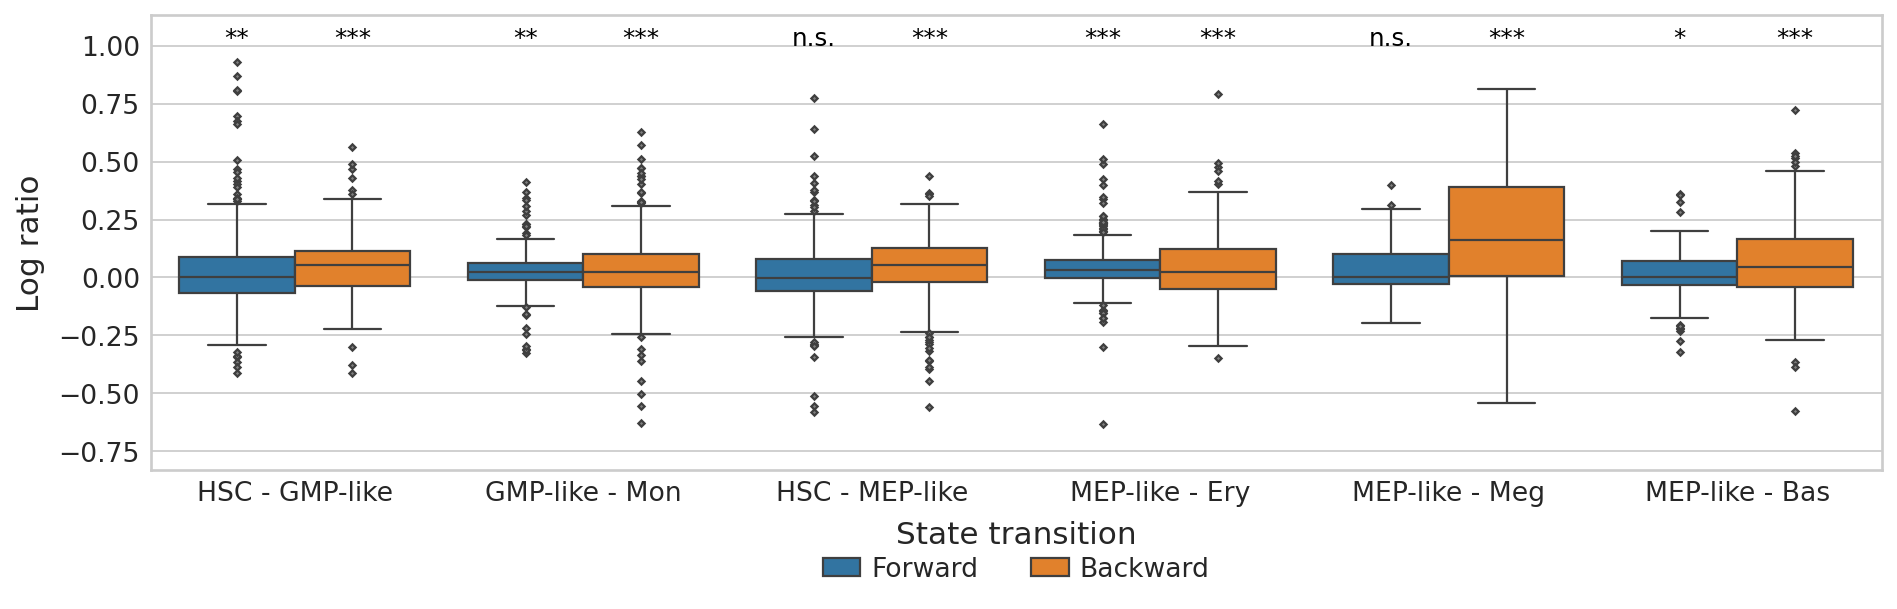

In [32]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(x="State transition", y="Log ratio", hue="Direction", data=score_df, flierprops=flierprops, ax=ax)

    # Calculate the maximum Y value from the data to set a uniform height for significance indicators
    y_max = score_df["Log ratio"].max()

    # Add significance indicators
    cell_types = score_df["State transition"].unique()
    categories = score_df["Direction"].unique()

    for i, cell_type in enumerate(cell_types):
        for j, category in enumerate(categories):
            star = sig_m[(sig_m["State transition"].isin([cell_type])) & (sig_m["Direction"].isin([category]))][
                "Sign"
            ].tolist()[0]

            # Calculate the position of the asterisk
            x = i + (j - 0.5) * 0.4  # Adjust the position of the asterisk
            y = y_max + 0.05  # Uniform height for all asterisks

            ax.text(x, y, star, ha="center", va="bottom", color="black")

    plt.ylim(score_df["Log ratio"].min() - 0.2, score_df["Log ratio"].max() + 0.2)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(categories))
    # Apply tight layout
    plt.tight_layout()

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "rgv_scv.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Comparing RegVelo and veloVI

### Measuring forward CBC

In [33]:
cluster_key = "cell_type"
rep = "X_pca"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_vi = vks["velovi"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_vi + 1)),
            }
        )
    )
score_df_forward = pd.concat(score_df)

100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


In [34]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df_forward["State transition"].isin([f"{source} - {target}"])
    a = score_df_forward.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [35]:
significances_forward = significances.copy()
significances_forward

{'HSC - GMP-like': 'n.s.',
 'GMP-like - Mon': 'n.s.',
 'HSC - MEP-like': 'n.s.',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': 'n.s.'}

### Measuring backward CBC

In [36]:
score_df = []
for source, target in tqdm(STATE_TRANSITIONS_REVERSE):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_vi = vks["velovi"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((2 - cbc_rgv) / (2 - cbc_vi)),
            }
        )
    )
score_df_backward = pd.concat(score_df)

100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


In [37]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS_REVERSE:
    obs_mask = score_df_backward["State transition"].isin([f"{source} - {target}"])
    a = score_df_backward.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [38]:
significances_backward = significances.copy()
significances_backward

{'GMP-like - HSC': '***',
 'Mon - GMP-like': '***',
 'MEP-like - HSC': '***',
 'Ery - MEP-like': '***',
 'Meg - MEP-like': '***',
 'Bas - MEP-like': '***'}

In [39]:
score_df_backward["State transition"] = score_df_backward["State transition"].apply(reverse_cluster)

In [40]:
score_df_forward.loc[:, "Direction"] = "Forward"
score_df_backward.loc[:, "Direction"] = "Backward"
score_df = pd.concat([score_df_forward, score_df_backward])

In [41]:
significances_backward = reverse_cluster_dict(significances_backward)
significances_backward

{'HSC - GMP-like': '***',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': '***',
 'MEP-like - Bas': '***'}

### Plot CBC

In [42]:
score_forward = []
for i in list(significances_forward.keys()):
    score_forward.append(significances_forward[i])

score_backward = []
for i in list(significances_backward.keys()):
    score_backward.append(significances_backward[i])

In [43]:
sig_m = pd.DataFrame(
    {
        "State transition": list(significances_forward.keys()) + list(significances_backward.keys()),
        "Direction": ["Forward"] * 6 + ["Backward"] * 6,
        "Sign": score_forward + score_backward,
    }
)

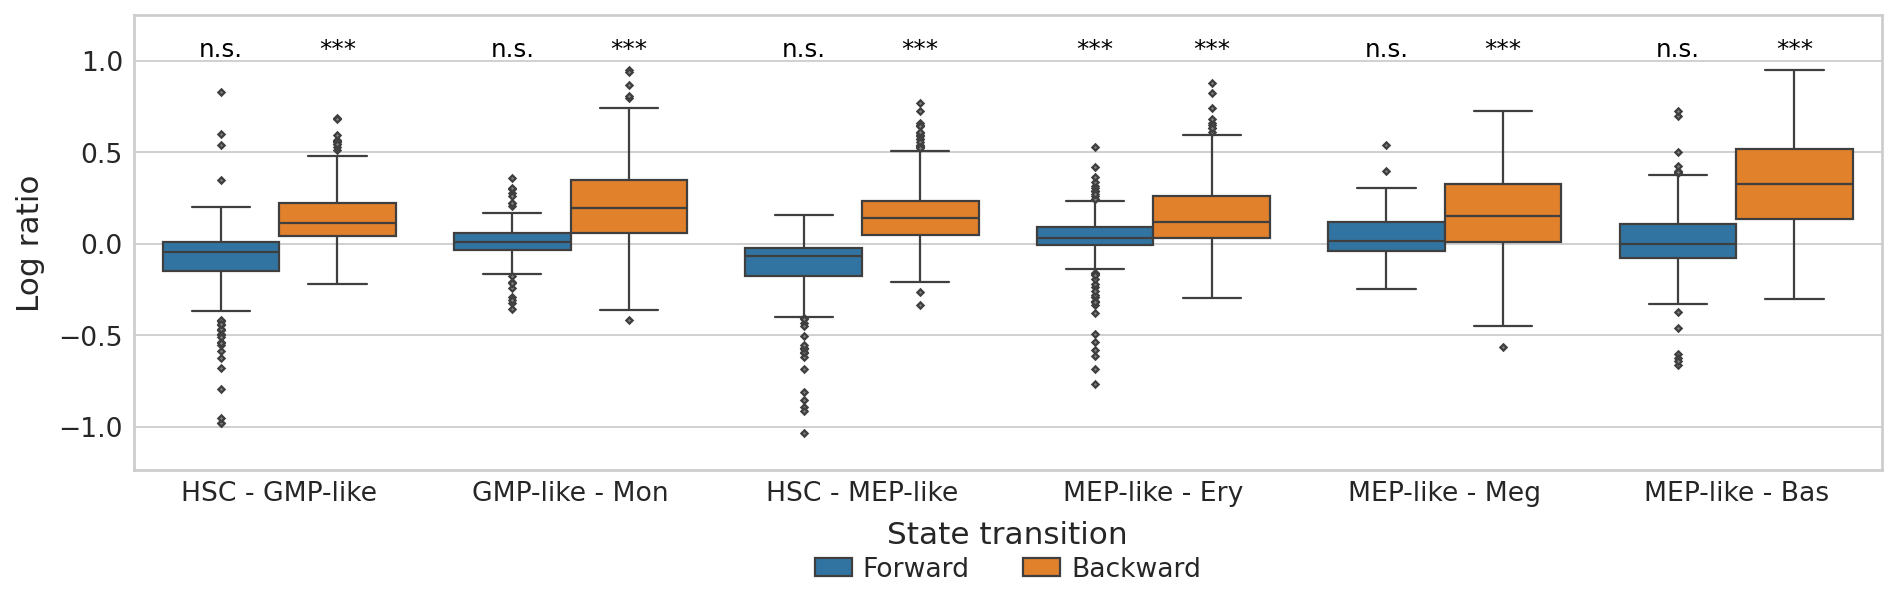

In [44]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(x="State transition", y="Log ratio", hue="Direction", data=score_df, flierprops=flierprops, ax=ax)

    # Calculate the maximum Y value from the data to set a uniform height for significance indicators
    y_max = score_df["Log ratio"].max()

    # Add significance indicators
    cell_types = score_df["State transition"].unique()
    categories = score_df["Direction"].unique()

    for i, cell_type in enumerate(cell_types):
        for j, category in enumerate(categories):
            star = sig_m[(sig_m["State transition"].isin([cell_type])) & (sig_m["Direction"].isin([category]))][
                "Sign"
            ].tolist()[0]

            # Calculate the position of the asterisk
            x = i + (j - 0.5) * 0.4  # Adjust the position of the asterisk
            y = y_max + 0.05  # Uniform height for all asterisks

            ax.text(x, y, star, ha="center", va="bottom", color="black")

    plt.ylim(score_df["Log ratio"].min() - 0.2, score_df["Log ratio"].max() + 0.3)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(categories))
    # Apply tight layout
    plt.tight_layout()
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "rgv_velovi.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Terminal state identification

In [45]:
ks = {}

for method in VELOCITY_METHODS:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_{method}.h5ad")
    ## construct graph
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ks[method] = 0.8 * vk + 0.2 * ck

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

In [46]:
thresholds = np.linspace(0.1, 1, 21)[:20]
estimators = {}
tsi = {}

In [47]:
for method in VELOCITY_METHODS[1:]:
    estimators[method] = cr.estimators.GPCCA(ks[method])
    tsi[method] = TSI_score(adata, thresholds, "cell_type", TERMINAL_STATES, estimators[method])

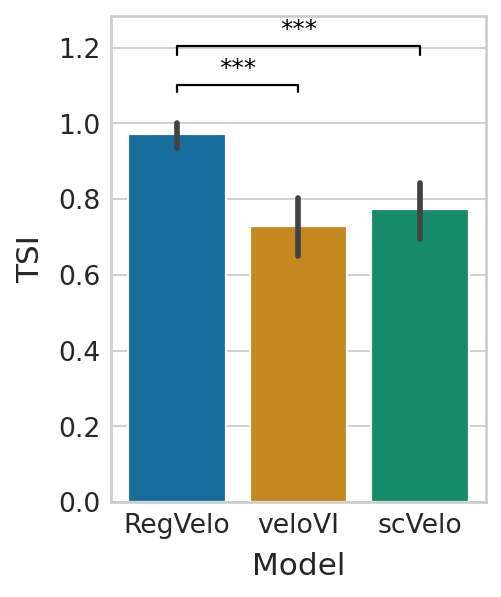

In [48]:
df = pd.DataFrame(
    {
        "TSI": tsi["regvelo"] + tsi["velovi"] + tsi["scvelo"],
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20,
    }
)
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)

    ttest_res = ttest_ind(tsi["regvelo"], tsi["velovi"], alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(tsi["regvelo"], tsi["scvelo"], alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9)

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "TSI_benchmark_update.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Show the stair plot

In [49]:
tsi_rgv_curve = plot_TSI(adata, estimators["regvelo"], 0.8, TERMINAL_STATES, "cell_type")
tsi_scv_curve = plot_TSI(adata, estimators["scvelo"], 0.8, TERMINAL_STATES, "cell_type")
tsi_vi_curve = plot_TSI(adata, estimators["velovi"], 0.8, TERMINAL_STATES, "cell_type")

In [50]:
### plot the recovery figure
df = pd.DataFrame(
    {
        "number_macrostate": range(0, 12),
        "RegVelo": [0] + tsi_rgv_curve,
        "veloVI": [0] + tsi_vi_curve,
        "scVelo": [0] + tsi_scv_curve,
    }
)
df = pd.melt(df, ["number_macrostate"])

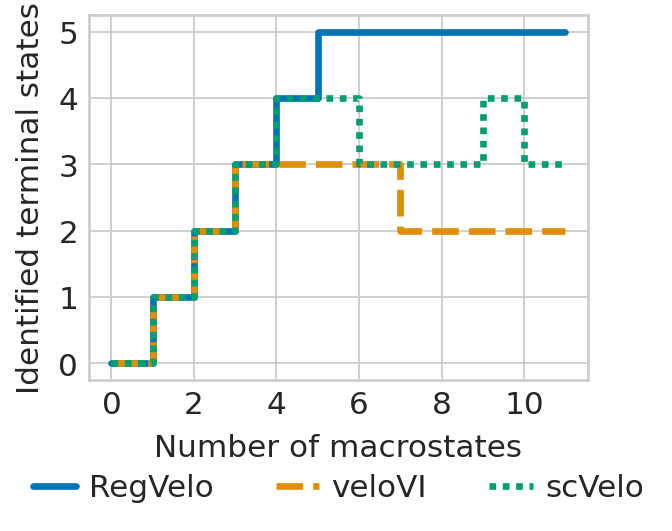

In [51]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    rcParams["figure.figsize"] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(
        x="number_macrostate",
        y="value",
        hue="variable",
        style="variable",
        palette=METHOD_PALETTE_TSI,
        drawstyle="steps-post",
        data=df,
        linewidth=3,
    )

    # Set labels and titles
    ax.set(ylabel="Number of correct predictions")
    plt.xlabel("Number of macrostates", fontsize=14)
    plt.ylabel("Identified terminal states", fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_xticklabels([0, 2, 4, 6, 8, 10])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4, fontsize=14)

    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / DATASET / "state_identification.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()